##Import Excel with data

In [289]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
excel_file_path = 'ml-final-project-data.xlsx'

data_sheet1 = pd.read_excel(excel_file_path, sheet_name='A')
data_sheet2 = pd.read_excel(excel_file_path, sheet_name='B')


df = pd.concat([data_sheet1, data_sheet2])

df_without_Y = df.drop('Y', axis=1)
Y = df['Y']

del df

##Verificar datos faltantes

In [290]:

valores_faltantes = df_without_Y.isnull().sum()


total_valores_faltantes = df_without_Y.isnull().sum().sum()

print("Suma total de valores faltantes en el DataFrame:", total_valores_faltantes)

Suma total de valores faltantes en el DataFrame: 0


##Imputación de datos atípicos

In [291]:
# calcular rango intercuatilico
Q1 = df_without_Y.quantile(0.25)
Q3 = df_without_Y.quantile(0.75)
IQR = Q3 - Q1


outliers = (df_without_Y < (Q1 - 1.5 * IQR)) | (df_without_Y > (Q3 + 1.5 * IQR))


for col in df_without_Y.columns:
    median = df_without_Y[col].median()


    limite_atipicos = len(df_without_Y) * 0.05


    if outliers[col].sum() > limite_atipicos:
        df_without_Y[col] = df_without_Y[col].where(~outliers[col], median)

##Normalización

In [292]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
# Normaliza
datos_normalizados = scaler.fit_transform(df_without_Y)

datos_normalizados = pd.DataFrame(datos_normalizados, columns=df_without_Y.columns)

del df_without_Y

##PCA

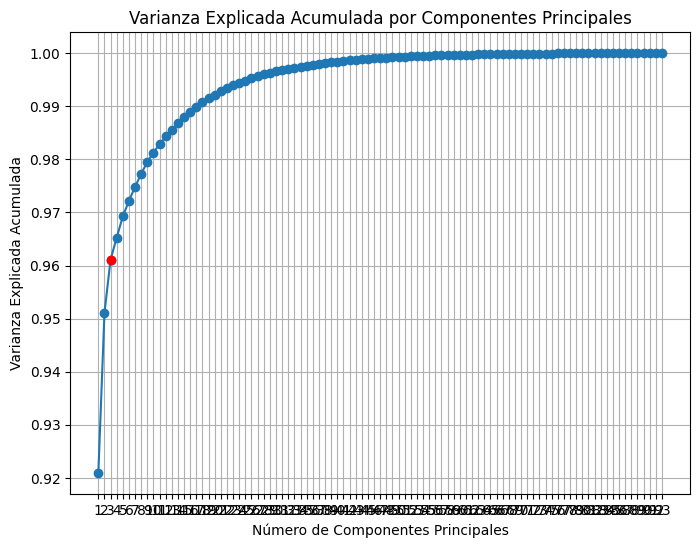

In [293]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
datos_escalados = scaler.fit_transform(datos_normalizados)


# aplicar el PSA
pca = PCA()
pca.fit(datos_escalados)


# Calcula la proporción de varianza explicada por cada componente
varianza_explicada = pca.explained_variance_ratio_



# gráfico de varianza
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(varianza_explicada) + 1), varianza_explicada.cumsum(), marker='o', linestyle='-')
plt.xticks(range(1, len(varianza_explicada) + 1))  # Establece los ticks del eje x
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por Componentes Principales')

# Cambiar el color del tercer punto (índice 2, considerando que la indexación comienza desde 0)
plt.plot(3, varianza_explicada.cumsum()[2], marker='o', markersize=6, color='red')  

plt.grid()
plt.show()


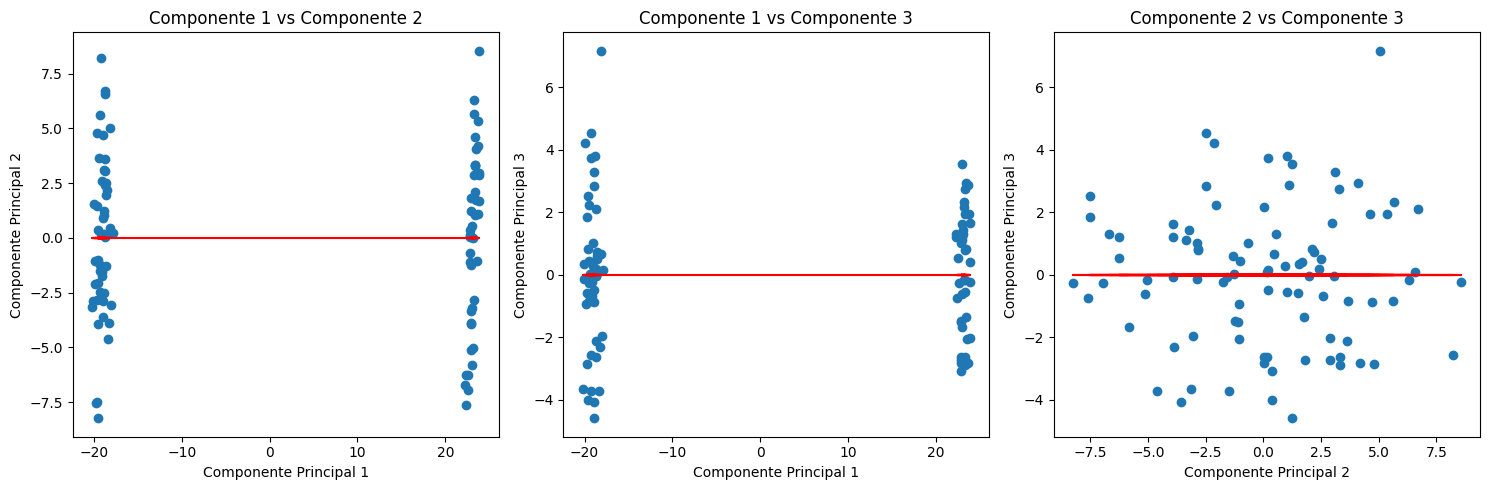

[0.92088522 0.030202   0.01005328]
[0.92088522 0.95108722 0.9611405 ]


In [294]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np


scaler = StandardScaler()
datos_escalados = scaler.fit_transform(datos_normalizados)


pca = PCA(n_components=3)
componentes_principales = pca.fit_transform(datos_escalados)

pca.fit(datos_escalados)



df_componentes = pd.DataFrame(data=componentes_principales, columns=['Componente 1', 'Componente 2', 'Componente 3'])


fig, axs = plt.subplots(1, 3, figsize=(15, 5))
def graficar_linea_regresion(x, y, ax):
    coeficientes = np.polyfit(x, y, 1)
    polinomio = np.poly1d(coeficientes)
    ax.plot(x, polinomio(x), color='red')

# Componente 1 vs Componente 2
axs[0].scatter(df_componentes['Componente 1'], df_componentes['Componente 2'])
graficar_linea_regresion(df_componentes['Componente 1'], df_componentes['Componente 2'], axs[0])
axs[0].set_xlabel('Componente Principal 1')
axs[0].set_ylabel('Componente Principal 2')
axs[0].set_title('Componente 1 vs Componente 2')

# Componente 1 vs Componente 3
axs[1].scatter(df_componentes['Componente 1'], df_componentes['Componente 3'])
graficar_linea_regresion(df_componentes['Componente 1'], df_componentes['Componente 3'], axs[1])
axs[1].set_xlabel('Componente Principal 1')
axs[1].set_ylabel('Componente Principal 3')
axs[1].set_title('Componente 1 vs Componente 3')

# Componente 2 vs Componente 3
axs[2].scatter(df_componentes['Componente 2'], df_componentes['Componente 3'])
graficar_linea_regresion(df_componentes['Componente 2'], df_componentes['Componente 3'], axs[2])
axs[2].set_xlabel('Componente Principal 2')
axs[2].set_ylabel('Componente Principal 3')
axs[2].set_title('Componente 2 vs Componente 3')



plt.tight_layout()
plt.show()

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())



##Red neuronal

In [295]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error



# objetivo
Y_train = Y  
X_train = datos_normalizados 



# transformar los datos de entrenamiento usando PCA
x_pca_train = pca.transform(X_train)


model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_pca_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_pca_train.shape[1],)),
    tf.keras.layers.Dense(1) 
])


model.compile(optimizer='adam', loss='mean_squared_error')
nn_all_mse = []
all_rmse = []
all_mae = []



kf = KFold(n_splits=10, shuffle=True)


for train_index, test_index in kf.split(x_pca_train):
    x_train_fold, x_val_fold = x_pca_train[train_index], x_pca_train[test_index]
    y_train_fold, y_val_fold = Y_train.iloc[train_index], Y_train.iloc[test_index]

 
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=30,          
        restore_best_weights=True  
    )

    
    model.fit(x_train_fold, y_train_fold, epochs=200, batch_size=10, validation_data=(x_val_fold, y_val_fold), callbacks=[early_stopping], verbose=0)

    
    predictions = model.predict(x_val_fold)

    # MSE, RMSE y MAE 
    mse = mean_squared_error(y_val_fold, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_fold, predictions)


    nn_all_mse.append(mse)
    all_rmse.append(rmse)
    all_mae.append(mae)



nn_avg_mse = np.mean(nn_all_mse)
nn_avg_rmse = np.mean(all_rmse)
nn_avg_mae = np.mean(all_mae)


print(f"Error cuadrático medio (MSE) promedio en validación cruzada: {nn_avg_mse}")

print(f"Raíz del Error cuadrático medio (RMSE) promedio en validación cruzada: {nn_avg_rmse}")
print(f"Error Absoluto Medio (MAE) promedio en validación cruzada: {nn_avg_mae}")


C:\Users\Hans\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 15ms/step
Error cuadrático medio (MSE) promedio en validación cruzada: 1.788662924789979
Raíz del Error cuadrático medio (RMSE) promedio en validación cruzada: 1.2857652558516715
Error Absoluto Medio (MAE) promedio en validación cruzada: 1.0167878208849166


##Regresión Polinomial

In [296]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import copy


RP_Y_train =   copy.deepcopy(Y)
RP_X_train = copy.deepcopy(datos_normalizados)

poly = PolynomialFeatures(degree=2)
RP_X_train_poly = poly.fit_transform(RP_X_train)


RP_X_train_pca = pca.fit_transform(RP_X_train_poly)

regressor = LinearRegression()
kf = KFold(n_splits=10, shuffle=True, random_state=42)


rp_mse_scores = []
rmse_scores = []
mae_scores = []



for train_index, test_index in kf.split(RP_X_train_pca):
    X_train_kfold, X_test_kfold = RP_X_train_pca[train_index], RP_X_train_pca[test_index]
    Y_train_kfold, Y_test_kfold = RP_Y_train.iloc[train_index], RP_Y_train.iloc[test_index]

    regressor.fit(X_train_kfold, Y_train_kfold)
    predictions = regressor.predict(X_test_kfold)

    mse = mean_squared_error(Y_test_kfold, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_test_kfold, predictions)

    rp_mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

pr_avg_mse = np.mean(rp_mse_scores)
pr_avg_rmse = np.mean(rmse_scores)
pr_avg_mae = np.mean(mae_scores)

print(f"Error cuadrático medio promedio en validación cruzada: {pr_avg_mse}")
print(f"Raíz del Error cuadrático medio promedio en validación cruzada: {pr_avg_rmse}")
print(f"Error Absoluto Medio promedio en validación cruzada: {pr_avg_mae}")


Error cuadrático medio promedio en validación cruzada: 2.3301512285824066
Raíz del Error cuadrático medio promedio en validación cruzada: 1.4663086650735175
Error Absoluto Medio promedio en validación cruzada: 1.2024632844803327


## SVR

In [297]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np


# objetivo
Y_train = Y  
X_train = datos_normalizados 


X_train_pca = pca.fit_transform(X_train)


model = SVR(kernel='rbf')
kf = KFold(n_splits=10, shuffle=True)
svr_mse_scores = []
rmse_scores = []
mae_scores = []

for train_index, test_index in kf.split(X_train_pca):
    X_train_kfold, X_test_kfold = X_train_pca[train_index], X_train_pca[test_index]
    Y_train_kfold, Y_test_kfold = Y_train.iloc[train_index], Y_train.iloc[test_index]

   
    model.fit(X_train_kfold, Y_train_kfold)

   
    predictions = model.predict(X_test_kfold)

   
    mse = mean_squared_error(Y_test_kfold, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_test_kfold, predictions)

    svr_mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)



svr_avg_mse = np.mean(svr_mse_scores)
svr_avg_rmse = np.mean(rmse_scores)
svr_avg_mae = np.mean(mae_scores)


print(f"Error cuadrático medio promedio en validación cruzada: {svr_avg_mse}")
print(f"Raíz del Error cuadrático medio promedio en validación cruzada: {svr_avg_rmse}")
print(f"Error Absoluto Medio promedio en validación cruzada: {svr_avg_mae}")


Error cuadrático medio promedio en validación cruzada: 2.569743588612831
Raíz del Error cuadrático medio promedio en validación cruzada: 1.5533614221335785
Error Absoluto Medio promedio en validación cruzada: 1.169534433490556


##Gradient Boosting

In [298]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np

Y_train = Y
X_train = datos_normalizados

X_train_pca = pca.fit_transform(X_train)



gradient_boosting = GradientBoostingRegressor()

kf = KFold(n_splits=10, shuffle=True)
gb_mse_scores = []
rmse_scores = []
mae_scores = []


for train_index, test_index in kf.split(X_train_pca):
    X_train_kfold, X_test_kfold = X_train_pca[train_index], X_train_pca[test_index]
    Y_train_kfold, Y_test_kfold = Y_train.iloc[train_index], Y_train.iloc[test_index]

    gradient_boosting.fit(X_train_kfold, Y_train_kfold)
    GB_y_pred = gradient_boosting.predict(X_test_kfold)

    mse = mean_squared_error(Y_test_kfold, GB_y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Y_test_kfold, GB_y_pred)

    gb_mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

gb_avg_mse = np.mean(gb_mse_scores)
gb_avg_rmse = np.mean(rmse_scores)
gb_avg_mae = np.mean(mae_scores)

print(f"Error cuadrático medio promedio en validación cruzada: {gb_avg_mse}")
print(f"Raíz del Error cuadrático medio promedio en validación cruzada: {gb_avg_rmse}")
print(f"Error Absoluto Medio promedio en validación cruzada: {gb_avg_mae}")


Error cuadrático medio promedio en validación cruzada: 3.254608660600141
Raíz del Error cuadrático medio promedio en validación cruzada: 1.7540421793700847
Error Absoluto Medio promedio en validación cruzada: 1.3501286997650739


Gráficas

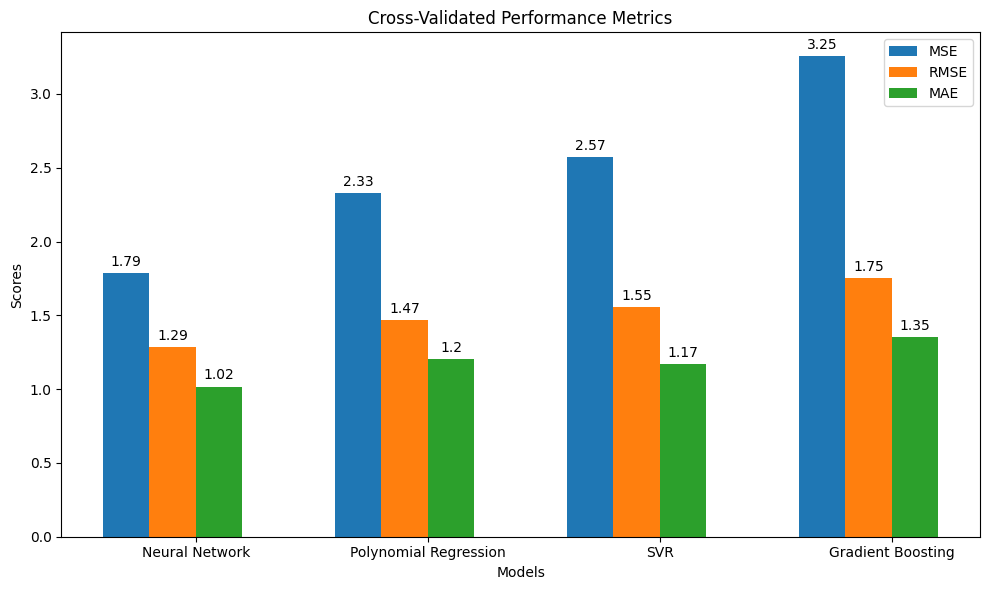

In [299]:
import matplotlib.pyplot as plt

models = ['Neural Network', 'Polynomial Regression', 'SVR', 'Gradient Boosting']
MSE = [nn_avg_mse, pr_avg_mse, svr_avg_mse, gb_avg_mse]
RMSE = [nn_avg_rmse, pr_avg_rmse, svr_avg_rmse, gb_avg_rmse]
MAE = [nn_avg_mae, pr_avg_mae, svr_avg_mae, gb_avg_mae]

bar_width = 0.2
index = range(len(models))



fig, ax = plt.subplots(figsize=(10, 6))


bar1 = ax.bar(index, MSE, bar_width, label='MSE')
bar2 = ax.bar([i + bar_width for i in index], RMSE, bar_width, label='RMSE')
bar3 = ax.bar([i + 2 * bar_width for i in index], MAE, bar_width, label='MAE')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Cross-Validated Performance Metrics')
ax.set_xticks([i + bar_width + bar_width / 2 for i in index])
ax.set_xticklabels(models)
ax.legend()



def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)
autolabel(bar3)

plt.tight_layout()
plt.show()

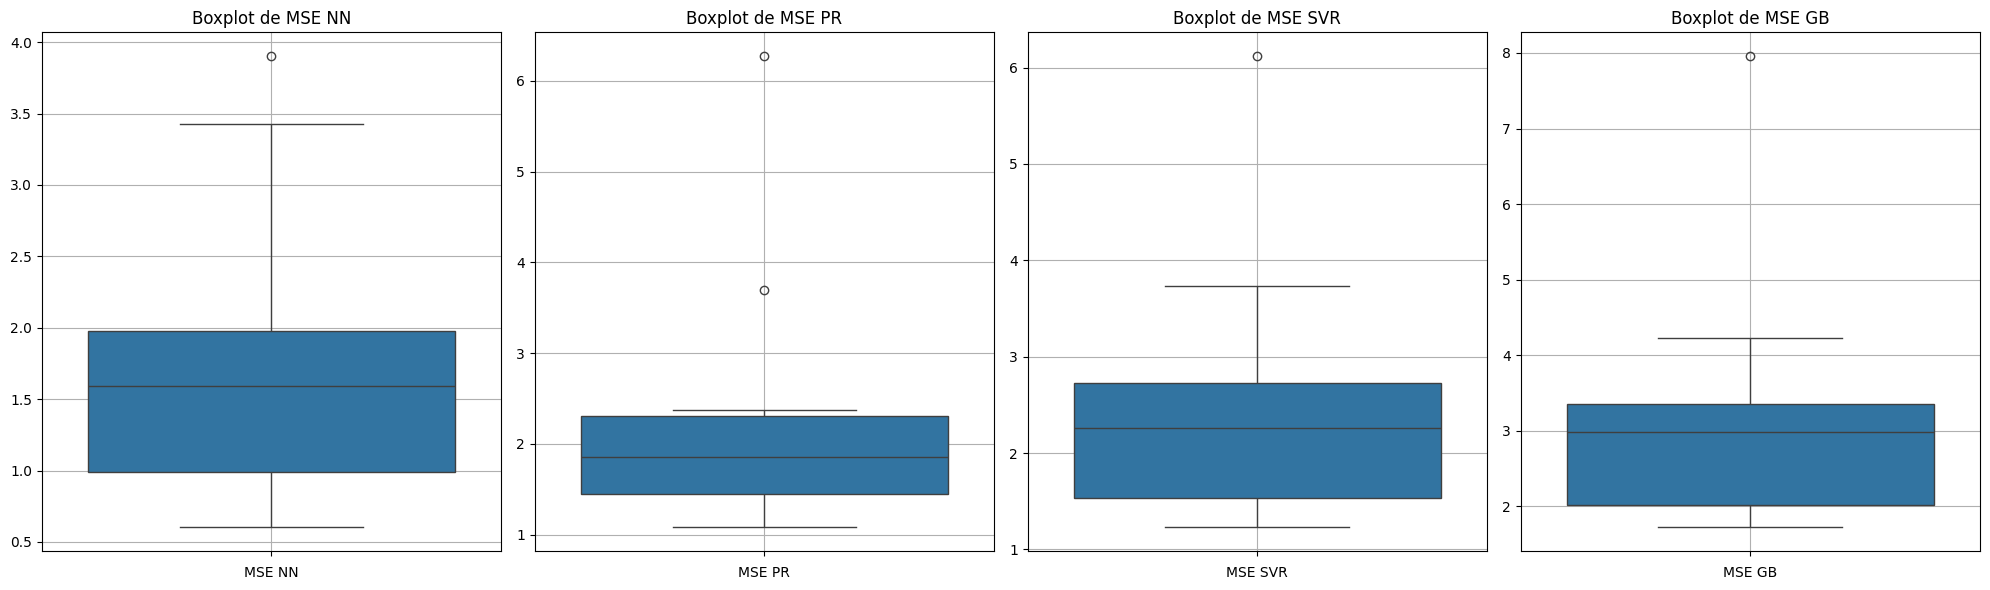

1.788662924789979;2.3301512285824066;2.569743588612831;3.254608660600141


In [300]:
import matplotlib.pyplot as plt
import seaborn as sns

metricas = [nn_all_mse, rp_mse_scores, svr_mse_scores, gb_mse_scores]
nombres_metricas = ['MSE NN', 'MSE PR', 'MSE SVR', 'MSE GB']
 

fig, axs = plt.subplots(1, 4, figsize=(20, 6))

for i, metrica in enumerate(metricas):
    sns.boxplot(metrica, ax=axs[i])
    axs[i].set_title(f'Boxplot de {nombres_metricas[i]}')
    axs[i].set_xlabel(nombres_metricas[i])
    axs[i].grid(True)


plt.tight_layout()
plt.show()

print(f"{nn_avg_mse};{pr_avg_mse};{svr_avg_mse};{gb_avg_mse}")